In [3]:
import pandas as pd

In [4]:
reviews = pd.read_csv('data/reviews.csv.gz')
listings = pd.read_csv('data/listings.csv.gz')
calendar = pd.read_csv('data/calendar.csv.gz')

## Normalise Reviews

In [ ]:
class NormaliseReviews():

    def __init__(self, reviews:pd.DataFrame) -> None:
        self.df = reviews

    # unique reviewers
    def normalise_reviewers(self):
        df = self.df
        #reviewer details
        users = df[['reviewer_id', 'reviewer_name']].drop_duplicates() 
        return users
    
    # unique reviews
    def normalise_reviews(self):
        df = self.df
        # unique reviews
        new_df  = df.dropna(axis=0).drop_duplicates()
        new_df.rename(columns={'id':'review_id'}, inplace=True)
        new_df = new_df.drop(columns=['reviewer_name'])
        new_df = new_df[['review_id', 'reviewer_id', 'listing_id', 'comments', 'date']]
        
        return reviews

## Normalise Listings

In [6]:
class NormaliseListings():

    def __init__(self, listings:pd.DataFrame) -> None:
        self.df = listings
        self.preprocessed = self._general_listings_preprocessing()
        self.droplist = self._construct_droplist()

    def _construct_droplist(self):
        df = self.preprocessed

        keys = ['neighbourhood', 'host', 'availability', 'nights', 'review', 'scrape']

        droplist = []
        for key in keys:
            subset = [col for col in df.columns if key in col]
            droplist += subset

        droplist = [col for col in droplist if 'id' not in col] 
        droplist += ['host_identity_verified']
        return droplist
    
    def _extract_url_cols(self, df, id_str: str, drop: bool):
        url_cols = [col for col in df.columns if 'url' in col]

        if drop:
            df = df.drop(columns=url_cols)
            return df
        else:
            id_col = df.columns[df.columns.get_loc(id_str)]
            return df[[id_col] + url_cols].drop_duplicates()

    def _general_listings_preprocessing(self):
        df = self.df
        night_data_cols = [col for col in df.columns if 'nights' in col]
        df.dropna(subset=night_data_cols, inplace=True)
        df.dropna(thresh=int(0.1 * df.shape[0]), axis=1, inplace=True)
        df.rename(
            columns={
                'id':'listing_id',
                'source': 'scrape_source',
                'neighborhood_overview':'neighbourhood_overview',
            }, 
            inplace=True
        )
        df['neighbourhood_id'] = df['neighbourhood_cleansed'].map(
            lambda x: x.replace('Ward', '').strip()
        )
        bool_cols = [
            'has_availability', 'instant_bookable', 'host_is_superhost', 
            'host_has_profile_pic', 'host_identity_verified'
        ]
        for col in bool_cols:
            df[col] = df[col] == 't'

        return df
    
    def normalise_hosts(self):
        # apply general preprocessing
        df = self.preprocessed
        
        # extract all columns with 'host' in the title
        host_cols = [
            col for col in df.columns if 'host' in col
        ]
        hosts = df[host_cols].drop_duplicates()

        hosts = self._extract_url_cols(hosts, 'host_id', drop=True)

        return hosts
    
    def normalise_neighbourhoods(self):
        # apply general preprocessing
        df = self.preprocessed

        # selected columns for neighbourhood table
        neighborhoods = df[
            ['neighbourhood_id', 'neighbourhood_cleansed']
        ].drop_duplicates()
        
        return neighborhoods
    
    def normalise_neighbourhood_overview(self):
        # apply general preprocessing
        df = self.preprocessed

        # selected columns for neighbourhood table
        neighborhoods = df[
            ['listing_id', 'neighbourhood_id', 'neighbourhood', 'neighbourhood_overview']
        ].drop_duplicates()
        
        return neighborhoods
    
    def normalise_availabilities(self):
        # apppy general preprocessing
        df = self.preprocessed

        availability_cols = [
            col for col in listings.columns if 'availability' in col
        ]
        availability = df[['listing_id'] + availability_cols]
        
        return availability
    
    def normalise_night_data(self):
        #apply general processing
        df = self.preprocessed
        
        nights_cols = [
            col for col in listings.columns if 'nights' in col
        ]
        nights_data = df[['listing_id'] + nights_cols]
        
        return nights_data
    
    def normalise_listing_reviews(self):
        #apply general processing
        df = self.preprocessed

        reviews_cols = [
            col for col in df.columns if 'review' in col
        ]
        reviews = df[['listing_id'] + reviews_cols]

        return reviews
    
    def normalise_scrape_details(self):
        # apply general preprocessing
        df = self.preprocessed

        scrape_cols = [
            col for col in df.columns if 'scrape' in col
        ]
        scrapes = df[scrape_cols].drop_duplicates()

        return scrapes
    
    def normalise_listings(self):
        # apply general preprocessing
        df = self.preprocessed

        relations_df = df.drop(columns=self.droplist)
        relations_df = self._extract_url_cols(relations_df, 'listing_id', drop=True)

        return relations_df


### Unique URL Listings

In [7]:
def extract_url_cols(df:pd.DataFrame, id_str:str, drop:bool=False):
    # extract all url based columns related to urls
    url_cols = [col for col in listings.columns if 'url' in col]
    id_col_idx = list(listings.columns).index(id_str)
    id_col = listings.columns[id_col_idx]
    
    if drop: 
        return df.drop(url_cols, inplace=True)
    else:
        url_df = df[[id_col] + url_cols].drop_duplicates()
        return url_df

In [8]:

reviews_norm = NormaliseReviews(reviews)
# Reviews Tables
users = reviews_norm.normalise_reviewers()
reviews = reviews_norm.normalise_reviews()


listings_norm = NormaliseListings(listings)
# Listings Tables
unique_hosts = listings_norm.normalise_hosts()
unique_neighbourhoods = listings_norm.normalise_neighbourhoods()
unique_neighbourhood_overviews = listings_norm.normalise_neighbourhood_overview()
availabilities = listings_norm.normalise_availabilities()
night_parameters = listings_norm.normalise_night_data()
listing_reviews =  listings_norm.normalise_listing_reviews()
listing_scrapes = listings_norm.normalise_scrape_details()
unique_listings = listings_norm.normalise_listings()

In [9]:
users.head(1)

,reviewer_id,reviewer_name
0,7175290,Morne


In [10]:
reviews.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,15007,9223897,2013-12-15,7175290,Morne,We spent a fantastic two week holiday at the B...


In [11]:
availabilities.head(1)

,listing_id,has_availability,availability_30,availability_60,availability_90,availability_365,availability_eoy
0,15007,True,13,31,50,230,50


In [12]:
night_parameters.head(1)

,listing_id,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
0,15007,2,120,2.0,2.0,1125.0,1125.0,2.0,1125.0


In [13]:
listing_reviews.head(1)

,listing_id,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,number_of_reviews_ly,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,15007,47,1,0,2,2013-12-15,2024-10-19,4.81,4.91,4.83,4.98,4.94,4.94,4.85,0.33


In [14]:
listing_scrapes.head(1)

,scrape_id,last_scraped,scrape_source,calendar_last_scraped
0,20250928034929,2025-09-28,city scrape,2025-09-28


In [15]:
unique_listings.columns

Index(['listing_id', 'scrape_id', 'name', 'description', 'host_id', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d',
       'instant_bookable', 'neighbourhood_id'],
      dtype='object')

In [16]:
unique_hosts.head(1)

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,59072,Dirk,2009-12-01,"Cape Town, South Africa",Proud to live in the beautiful city of Cape To...,within a few hours,100%,88%,False,7.0,19.0,"['email', 'phone', 'work_email']",True,True,1,1,0,0


## Hypothesis Testing

Do instantly bookable listings have a higher review score rating? 

$H_{o}$: Instant bookable listings ratings are not higher than normal listings.  
$H_{0}$ $\mu_{instant}$ = $\mu_{normal}$  
$H_{0}$ $\mu_{instant}$ - $\mu_{normal}$ = 0

$H_{A}$: Instant bookable listings perform are higher than normal listings.  
$H_{0}$ $\mu_{instant}$ > $\mu_{normal}$  
$H_{0}$ $\mu_{instant}$ - $\mu_{normal}$ > 0

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

In [18]:
listing_ratings = pd.merge(unique_listings, listing_reviews, on=['listing_id'])[['listing_id', 'instant_bookable', 'review_scores_rating']].dropna()

In [19]:
listing_ratings.head()

,listing_id,instant_bookable,review_scores_rating
0,15007,False,4.81
2,15077,False,5.00
3,15199,False,4.50
5,15480,False,4.36
6,15704,False,5.00


In [20]:
listing_ratings.describe()

,listing_id,review_scores_rating
count,2.075100e+04,20751.000000
mean,6.241820e+17,4.754541
std,5.636219e+17,0.444636
min,1.500700e+04,1.000000
25%,3.184738e+07,4.700000
50%,7.507840e+17,4.890000
75%,1.159967e+18,5.000000
max,1.515762e+18,5.000000


In [21]:
xbar = listing_ratings.groupby('instant_bookable')['review_scores_rating'].mean()
stdv = listing_ratings.groupby('instant_bookable')['review_scores_rating'].std()
num = listing_ratings.groupby('instant_bookable')['review_scores_rating'].count()

In [22]:
xbar_instant, xbar_normal = xbar.values
print('instant', xbar_instant)
print('normal', xbar_normal)

instant 4.799827267932489
normal 4.631504567436862


In [23]:
stdv_instant, stdv_normal = stdv.values
print('instant', stdv_instant)
print('normal', stdv_normal)

instant 0.36510374083715263
normal 0.5933014894678661


In [24]:
num_instant, num_normal = num.values
print('instant', num_instant)
print('normal', num_normal)

instant 15168
normal 5583


In [25]:
mean_diff = xbar_instant - xbar_normal
se_diff = np.sqrt(stdv_instant ** 2 / num_instant + stdv_normal ** 2 / num_normal)
t_stat = mean_diff / se_diff
t_stat

np.float64(19.859372113209208)

In [26]:
ddof = num_instant + num_normal - 2
p_val = 1 - t.cdf(t_stat, df=ddof)
p_val

np.float64(0.0)

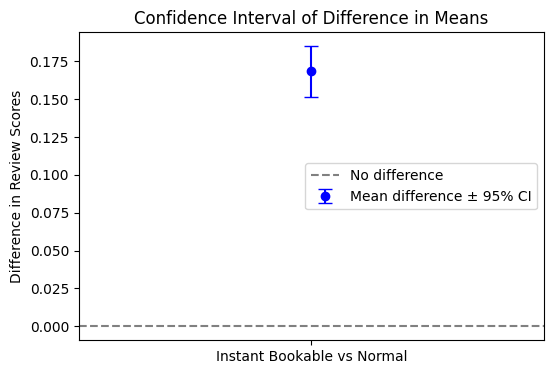

In [27]:
# Confidence level (95%)
alpha = 0.05
t_crit = t.ppf(1 - alpha/2, df=ddof)

# Confidence interval bounds
ci_lower = mean_diff - t_crit * se_diff
ci_upper = mean_diff + t_crit * se_diff

# Plotting
plt.figure(figsize=(6,4))
plt.axhline(0, color='gray', linestyle='--', label='No difference')
plt.errorbar(1, mean_diff, yerr=t_crit*se_diff, fmt='o', color='blue', capsize=5, label='Mean difference ± 95% CI')
plt.xticks([1], ['Instant Bookable vs Normal'])
plt.ylabel('Difference in Review Scores')
plt.title('Confidence Interval of Difference in Means')
plt.legend()
plt.show()


In [28]:
# Calculate mean rating by class
mean_ratings = listing_ratings.groupby('instant_bookable')['review_scores_rating'].mean()

# Identify which class has a higher mean rating
higher_class = mean_ratings.idxmax()
higher_mean = mean_ratings.max()

print("Class with higher average rating:", higher_class)
print("Mean rating of this class:", higher_mean)


Class with higher average rating: False
Mean rating of this class: 4.799827267932489


### Hypothesis Test Conclusion

There is a statistically significant difference in review scores between instant bookable and non-instant bookable listings, with the confidence interval visualization reinforcing this result clearly.

## Logistic Regression

### Predict Superhost Status.

The goal of this project is to develop a predictive model to identify which Airbnb hosts are likely to achieve Superhost status based on various host-related features such as response time, acceptance rate, verification methods, and listing counts. By understanding the key factors that influence Superhost designation, we aim to support targeted interventions to enhance host performance and improve guest satisfaction.

A Superhost on Airbnb is a top-performing host recognized for consistently providing exceptional hospitality, a status indicated by a badge on their listing and profile. To achieve this status, hosts must meet specific performance criteria, such as a high rating, low cancellation rate, high response rate, and a minimum number of bookings, which are evaluated automatically by Airbnb

In [29]:
unique_hosts.head()

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,59072,Dirk,2009-12-01,"Cape Town, South Africa",Proud to live in the beautiful city of Cape To...,within a few hours,100%,88%,False,7.0,19.0,"['email', 'phone', 'work_email']",True,True,1,1,0,0
1,59318,Linda,2009-12-02,NaN,NaN,a few days or more,0%,33%,False,7.0,20.0,"['email', 'phone']",True,True,5,5,0,0
2,59342,Georg,2009-12-02,Gibraltar,challenge us please! we love to perform!,within a few hours,100%,80%,False,7.0,7.0,"['email', 'phone']",True,True,6,1,5,0
3,59694,Alexa,2009-12-03,"Cape Town, South Africa",Professional businesswoman dedicated to provid...,NaN,NaN,NaN,False,2.0,2.0,"['email', 'phone']",True,True,1,1,0,0
4,60196,Ian,2009-12-05,"Cape Town, South Africa",NaN,NaN,NaN,NaN,False,1.0,2.0,"['email', 'phone']",True,False,1,1,0,0


In [30]:
response_time_classes = unique_hosts['host_response_time'].unique()
response_time_classes

array(['within a few hours', 'a few days or more', nan, 'within an hour',
       'within a day'], dtype=object)

In [31]:
unique_hosts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14134 entries, 0 to 26875
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_id                                       14134 non-null  int64  
 1   host_name                                     14130 non-null  object 
 2   host_since                                    14130 non-null  object 
 3   host_location                                 10152 non-null  object 
 4   host_about                                    5924 non-null   object 
 5   host_response_time                            9343 non-null   object 
 6   host_response_rate                            9343 non-null   object 
 7   host_acceptance_rate                          11014 non-null  object 
 8   host_is_superhost                             14134 non-null  bool   
 9   host_listings_count                           14130 non-null  floa

In [32]:
unique_hosts_exp = unique_hosts.copy()
unique_hosts_exp.columns = [col.replace('host_', '') for col in unique_hosts_exp.columns ]
unique_hosts_exp.drop(columns=['name', 'about', 'location'], inplace=True)
unique_hosts_exp.dropna(axis=0, subset=['response_time', 'response_rate', 'acceptance_rate'], inplace=True)
unique_hosts_exp.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9111 entries, 0 to 26862
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       9111 non-null   int64  
 1   since                                    9111 non-null   object 
 2   response_time                            9111 non-null   object 
 3   response_rate                            9111 non-null   object 
 4   acceptance_rate                          9111 non-null   object 
 5   is_superhost                             9111 non-null   bool   
 6   listings_count                           9111 non-null   float64
 7   total_listings_count                     9111 non-null   float64
 8   verifications                            9111 non-null   object 
 9   has_profile_pic                          9111 non-null   bool   
 10  identity_verified                        9111 non-nu

In [33]:
response_time_classes = unique_hosts_exp['response_time'].unique()
response_time_classes

array(['within a few hours', 'a few days or more', 'within an hour',
       'within a day'], dtype=object)

In [34]:
rate_cols = ['acceptance_rate', 'response_rate']
for col in rate_cols:
    unique_hosts_exp[col] = unique_hosts_exp[col].str.replace('%', '').astype(int)
unique_hosts_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9111 entries, 0 to 26862
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       9111 non-null   int64  
 1   since                                    9111 non-null   object 
 2   response_time                            9111 non-null   object 
 3   response_rate                            9111 non-null   int64  
 4   acceptance_rate                          9111 non-null   int64  
 5   is_superhost                             9111 non-null   bool   
 6   listings_count                           9111 non-null   float64
 7   total_listings_count                     9111 non-null   float64
 8   verifications                            9111 non-null   object 
 9   has_profile_pic                          9111 non-null   bool   
 10  identity_verified                        9111 non-nu

In [35]:
listing_count_cols = ['listings_count', 'total_listings_count']  
for col in listing_count_cols:  
   if (unique_hosts_exp[col] % 1 == 0).sum() == unique_hosts_exp.shape[0]:
      unique_hosts_exp[col] = unique_hosts_exp[col].astype(int)
      print(col, True)
unique_hosts_exp.info()

listings_count True
total_listings_count True
<class 'pandas.core.frame.DataFrame'>
Index: 9111 entries, 0 to 26862
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   id                                       9111 non-null   int64 
 1   since                                    9111 non-null   object
 2   response_time                            9111 non-null   object
 3   response_rate                            9111 non-null   int64 
 4   acceptance_rate                          9111 non-null   int64 
 5   is_superhost                             9111 non-null   bool  
 6   listings_count                           9111 non-null   int64 
 7   total_listings_count                     9111 non-null   int64 
 8   verifications                            9111 non-null   object
 9   has_profile_pic                          9111 non-null   bool  
 10  identity_verified 

In [36]:
numeric_cols = [col for col in unique_hosts_exp.columns if unique_hosts_exp[col].dtype == 'int']
numeric_cols = numeric_cols[1:]
numeric_uniqe_hosts_exp = unique_hosts_exp[numeric_cols]
unique_hosts_exp_grp = unique_hosts_exp.drop(columns=['id']).groupby('is_superhost')
unique_hosts_exp_grp[numeric_cols].mean()

,response_rate,acceptance_rate,listings_count,total_listings_count,calculated_listings_count,calculated_listings_count_entire_homes,calculated_listings_count_private_rooms,calculated_listings_count_shared_rooms
is_superhost,,,,,,,,
False,89.617956,75.539377,3.576304,6.506300,2.061078,1.766538,0.282289,0.005425
True,98.278481,91.655873,2.933765,3.844569,2.412423,2.165440,0.241389,0.000589


In [37]:
len(numeric_cols)

8

In [38]:
unique_hosts_exp_grp['response_time'].value_counts()

is_superhost  response_time     
False         within an hour        3095
              within a few hours    1140
              within a day          1054
              a few days or more     425
True          within an hour        2458
              within a few hours     692
              within a day           234
              a few days or more      13
Name: count, dtype: int64

In [39]:
unique_hosts_exp_grp['has_profile_pic'].value_counts()

is_superhost  has_profile_pic
False         True               5453
              False               261
True          True               3343
              False                54
Name: count, dtype: int64

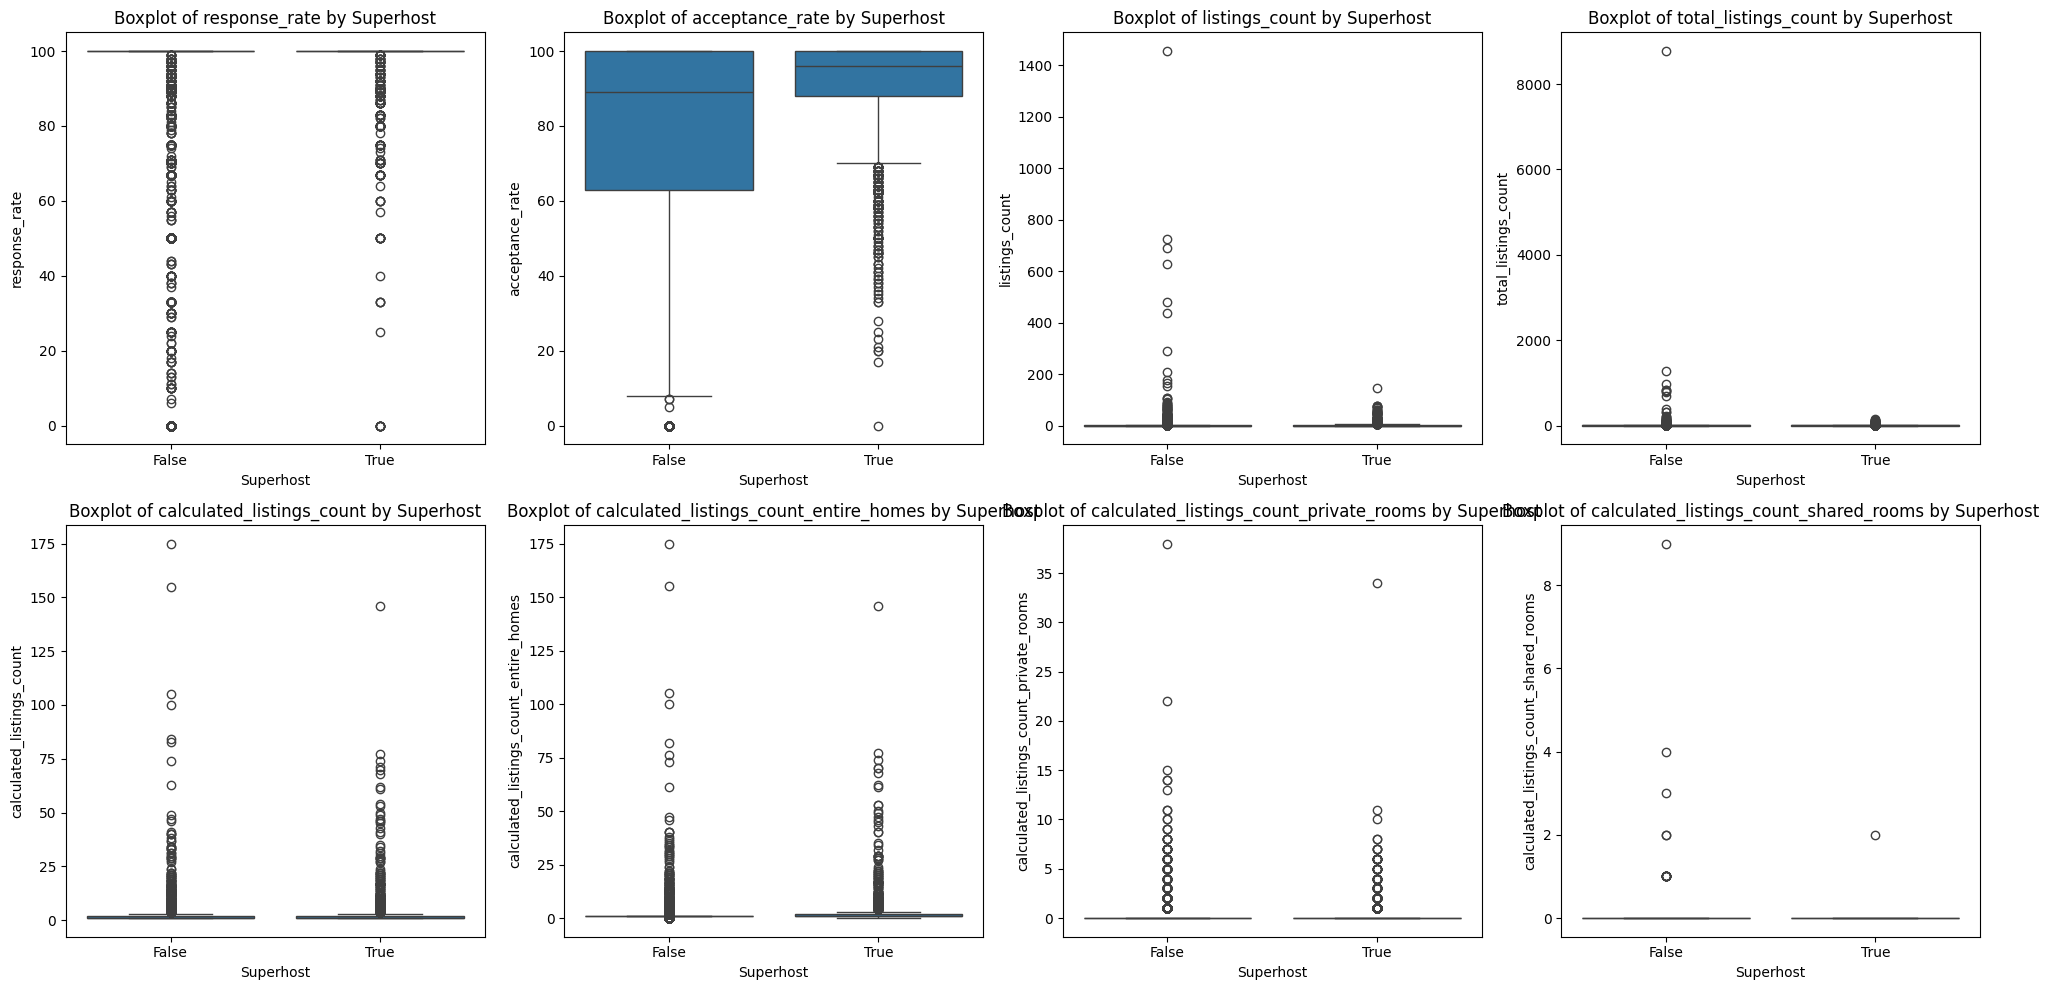

In [40]:
# Create a 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust size if needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through columns and plot boxplots by 'host_is_superhost'
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='is_superhost', y=col, data=unique_hosts_exp, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Superhost')
    axes[i].set_xlabel('Superhost')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

## Assessing Correlations

`acceptance_rate` and `response_rate are moderately` correlated 0.51  
`total_listings_count` and `listings_count are higly` correlated 0.83  
`calculated_listings_count` and `calculated_listings_count_entire_homes` are very higly correlated 0.93 


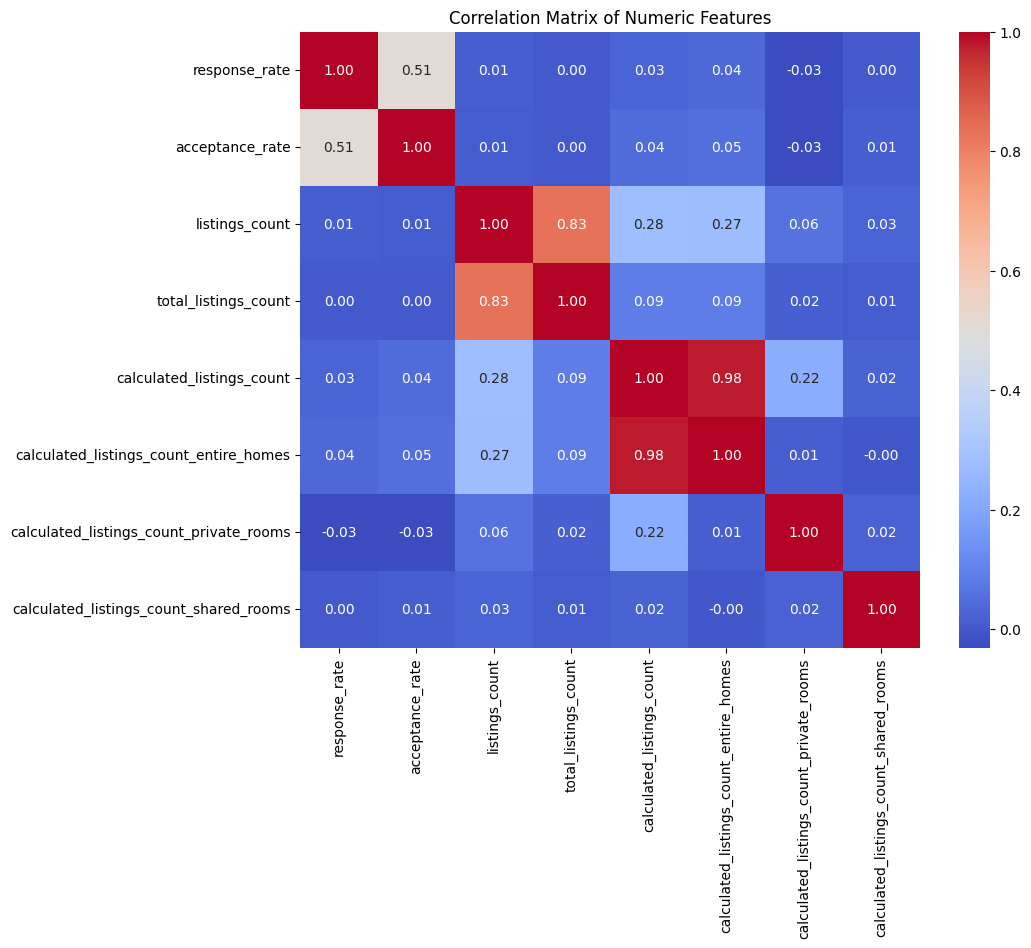

In [41]:
num_corr = numeric_uniqe_hosts_exp.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [42]:
# Define the order based on typical Airbnb response times
response_time_order = [
    'within an hour',
    'within a few hours',
    'within a day',
    'a few days or more'
]

# Convert to ordered categorical type
unique_hosts_exp['response_time'] = pd.Categorical(unique_hosts_exp['response_time'],
    categories=response_time_order,
    ordered=True
)

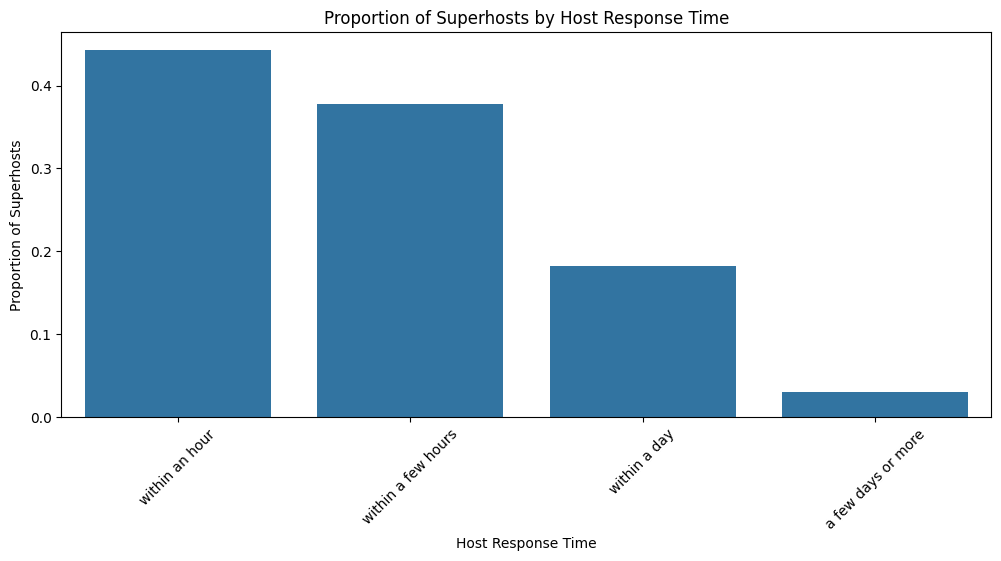

In [43]:
# Create a summary dataframe with proportions of Superhosts per response time level
prop_df = unique_hosts_exp.groupby('response_time', observed=False)['is_superhost'].mean().reset_index()
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# Plot barplot
sns.barplot(x='response_time', y='is_superhost', data=prop_df)
plt.xlabel('Host Response Time')
plt.ylabel('Proportion of Superhosts')
plt.title('Proportion of Superhosts by Host Response Time')
plt.xticks(rotation=45)
plt.show()

In [47]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create contingency table of observed counts
contingency_table_time = pd.crosstab(unique_hosts_exp['response_time'], unique_hosts_exp['is_superhost'])
contingency_table_rate = pd.crosstab(unique_hosts_exp['response_rate'], unique_hosts_exp['is_superhost'])

# Perform chi-square test
cont_tables = [contingency_table_rate, contingency_table_time]

results = []
for tab in cont_tables:
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_time)
    print("Chi-square statistic:", chi2_stat)
    print("Degrees of freedom:", dof)
    print("P-value:", p_val)

    # Interpret the p-value
    alpha = 0.05
    if p_val < alpha:
        print("Reject null hypothesis: Variables are dependent (significant association).")
    else:
        print("Fail to reject null hypothesis: No significant association between variables.")

    print()


Chi-square statistic: 537.7668512319605
Degrees of freedom: 3
P-value: 3.1149738380066754e-116
Reject null hypothesis: Variables are dependent (significant association).

Chi-square statistic: 537.7668512319605
Degrees of freedom: 3
P-value: 3.1149738380066754e-116
Reject null hypothesis: Variables are dependent (significant association).



In [49]:
from scipy.stats import ttest_ind, mannwhitneyu, pointbiserialr

numeric_cols = [
    'response_rate', 'acceptance_rate', 'listings_count',
    'total_listings_count', 'calculated_listings_count',
    'calculated_listings_count_entire_homes', 'calculated_listings_count_private_rooms',
    'calculated_listings_count_shared_rooms'
]

# Convert target to integer for correlation
target = unique_hosts_exp['is_superhost'].astype(int)

for col in numeric_cols:
    group_true = unique_hosts_exp[unique_hosts_exp['is_superhost'] == True][col].dropna()
    group_false = unique_hosts_exp[unique_hosts_exp['is_superhost'] == False][col].dropna()

    # t-test
    t_stat, t_pval = ttest_ind(group_true, group_false, nan_policy='omit')

    # Mann-Whitney U test
    u_stat, u_pval = mannwhitneyu(group_true, group_false, alternative='two-sided')

    # Point-biserial correlation
    valid_idx = unique_hosts_exp[col].notnull()
    corr, corr_pval = pointbiserialr(target[valid_idx], unique_hosts_exp.loc[valid_idx, col])

    print(f"Variable: {col}")
    print(f"  t-test p-value: {t_pval:.4f}")
    print(f"  Mann-Whitney U test p-value: {u_pval:.4f}")
    print(f"  Point-biserial correlation: {corr:.4f} (p-value: {corr_pval:.4f})\n")


Variable: response_rate
  t-test p-value: 0.0000
  Mann-Whitney U test p-value: 0.0000
  Point-biserial correlation: 0.1995 (p-value: 0.0000)

Variable: acceptance_rate
  t-test p-value: 0.0000
  Mann-Whitney U test p-value: 0.0000
  Point-biserial correlation: 0.2884 (p-value: 0.0000)

Variable: listings_count
  t-test p-value: 0.1803
  Mann-Whitney U test p-value: 0.0000
  Point-biserial correlation: -0.0140 (p-value: 0.1803)

Variable: total_listings_count
  t-test p-value: 0.1999
  Mann-Whitney U test p-value: 0.0000
  Point-biserial correlation: -0.0134 (p-value: 0.1999)

Variable: calculated_listings_count
  t-test p-value: 0.0021
  Mann-Whitney U test p-value: 0.0000
  Point-biserial correlation: 0.0322 (p-value: 0.0021)

Variable: calculated_listings_count_entire_homes
  t-test p-value: 0.0003
  Mann-Whitney U test p-value: 0.0000
  Point-biserial correlation: 0.0375 (p-value: 0.0003)

Variable: calculated_listings_count_private_rooms
  t-test p-value: 0.0884
  Mann-Whitney U t